# **Mass Protest Notes**

The [dataset](https://raw.githubusercontent.com/datacamp/careerhub-data/master/Mass%20Protest%20Data/protest_data.csv) contains notes published about mass protests recorded in different parts of the world. For this section sentimental analysis will be carried out to get insight from these texts. 

- First let's import the necessary packages and the dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud
from langdetect import detect_langs

protest_notes = pd.read_csv('protest_notes.csv')
print(protest_notes.head())

                                       protest_notes
0  canada s railway passenger system was finally ...
1  protestors were only identified as young peopl...
2  the queen, after calling on canadians to remai...
3  canada s federal government has agreed to acqu...
4  protests were directed against the state due t...


## Removing Unwanted Characters

There are non letter characters in text that ought to be removed before analysis. 

- Here, we'll use the `.replace()` method together with the `str` accessor. For confirmation purposes, we'll transform the text to lowercase using the `lower()` method.

- Note that there is some discrepancies with some letters and words such as `canada s` and `o neill`. The issue will be solved later on.

In [2]:
protest_notes['protest_notes'] = protest_notes.protest_notes\
        .str.replace('[^a-zA-Z]', ' ', regex=True)\
        .str.lower()
print(protest_notes)

                                          protest_notes
0     canada s railway passenger system was finally ...
1     protestors were only identified as young peopl...
2     the queen  after calling on canadians to remai...
3     canada s federal government has agreed to acqu...
4     protests were directed against the state due t...
...                                                 ...
5347  supreme court ruling on monday gives sir micha...
5348  o neill announces speech for the following day...
5349  students boycotted class in response to propos...
5350  protesting against a proposed six month delay ...
5351  protesting gov ts deal w australia over asylum...

[5352 rows x 1 columns]


$\checkmark$ We can perform these steps using the `word_tokenize()` function from `nltk`.

## Word Count

- Just out of curiosity, let's get the number of words contained in each note.

In [3]:
protest_notes['word_count'] = protest_notes.protest_notes\
        .str.split()\
        .str.len()
protest_notes.word_count.head()

0    129
1     12
2    155
3    205
4     22
Name: word_count, dtype: int64

- It may also be beneficial to look at the highest and lowest word counts distribution. Something interesting pops up. There are actually 88 notes entries with only one word. Note also that the y-axis are index position of the notes in the data

Number of notes with one word:  88


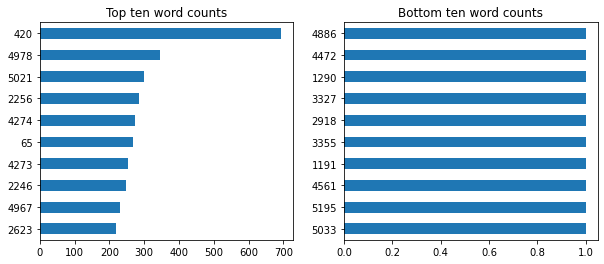

In [4]:
bottom_ten = protest_notes.word_count.sort_values()
top_ten = protest_notes.word_count.sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
top_ten[:10].sort_values().plot(ax=ax1, kind='barh')
bottom_ten[:10].sort_values().plot(ax=ax2, kind='barh')
ax1.set_title('Top ten word counts')
ax2.set_title('Bottom ten word counts');

print('Number of notes with one word: ', sum(bottom_ten == 1))

- Before making any decision, it is advisable to have a look at these one word entries. Upon doing so, I'll leave them because most of them still provide insight related to the protest.

In [5]:
protest_notes[(protest_notes.word_count == 1)]['protest_notes'].unique()

array(['unspecified', 'national', 'strike', 'taxes', 'hanchongnyon',
       'jobs', 'max        ', '    aggressive', 'basing', 'beef',
       'appointments', '     arrested', 'egat', 'wto', 'pipeline',
       'privatization', 'evictions'], dtype=object)

- Out of these 88 one word occurrence, 44 of them are `'unspecified'`.

In [6]:
protest_notes[(protest_notes.protest_notes == 'unspecified')].shape

(44, 2)

## Calculating the Valence of the Reviews

- Before calculating the polarity and subjectivity we'll concatenate the review for the whole dataset

In [7]:
all_reviews = protest_notes.protest_notes.tolist()
all_reviews = ''.join(all_reviews)

- Upon calculating the polarity and subjectivity for the whole `review` column. The polarity measure of 0.02 portrays a neutral emotion while a subjectivity score of 0.34 reveals that the notes are objective.

In [8]:
all_reviews_blob = TextBlob(all_reviews)
all_reviews_blob.sentiment

Sentiment(polarity=0.01917806383025101, subjectivity=0.343109821055826)

## Word Frequency

- Let's check the word frequency in our data. 

### Word Cloud

- Before diving into much details about the word frequency in the dataset let's create a tag cloud. This way, we can see that the sentiments are indeed related to protest. 

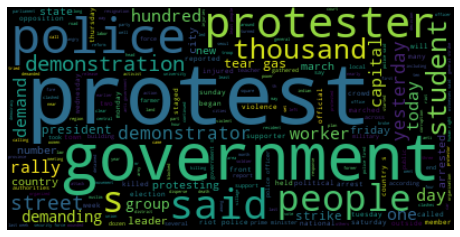

In [9]:
plt.subplots(figsize=(8, 6))
all_review_cloud = WordCloud()\
                  .generate(all_reviews)
plt.imshow(all_review_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### `CountVectorizer()`

- Let's confirm our tag cloud. Here we'll use the `CountVectorizer()`. Additionally, we'll use `uni-grams` and limit the number of features created  to 1000 most common words in English. Note that once we limit these features, setting the document frequency to 0.1 and 0.9 as the minimum number and maximum thresholds of text may not be applicable. Thankfully, we are using unigrams. For posterity, we'll perform fit and transform separately. 

In [10]:
cv = CountVectorizer(max_features=1000, 
                     stop_words='english', 
                     ngram_range=(1, 1))
cv.fit(protest_notes.protest_notes)
transformed_notes = cv.transform(protest_notes.protest_notes)
transformed_notes

<5352x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 78455 stored elements in Compressed Sparse Row format>

- Once we obtain the sparse matrix we can examine to see if our analysis is relevant. From the result, we are on the right track.

In [11]:
data = transformed_notes.toarray()
columns = cv.get_feature_names_out()
cv_data = pd.DataFrame(data, columns=columns)
counts_value = cv_data.sum().sort_values(ascending=False)
counts_value

police        2049
government    1642
protest       1528
people        1243
said          1153
              ... 
historic        23
occupation      23
imports         23
increased       23
criminal        23
Length: 1000, dtype: int64

- Lets plot words greater than 700 counts in the data. From the plot there are 9 words greater than or equal to 700.

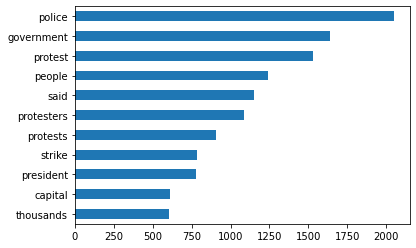

In [12]:
counts_value[counts_value>=600]\
        .sort_values()\
        .plot(kind='barh');

## Determing the Language

So far we've assumed that the notes have been written in English. Is this the case? 

- Let's iterate through our data to determine the languages used.

In [13]:
from langdetect import DetectorFactory
DetectorFactory.seed = 0

languages = []

for row in range(len(protest_notes)):
    det_langs = detect_langs(protest_notes.iloc[row, 0])
    languages.append(det_langs)

- From the first ten entries of the `languages` list, it is evident that first ten notes in the DataFrame are all in English.

In [14]:
print(languages[:10])

[[en:0.9999979199596354], [en:0.9999953443911908], [en:0.999995808946633], [en:0.9999948891149485], [en:0.9999964340259099], [en:0.9999973234447425], [en:0.999995780701356], [en:0.9999974891434059], [en:0.9999969132293569], [en:0.9999960124001721]]


- Before creating a column in the DataFrame to hold the language type, we'll have to do some string cleaning. What the function below mean is that we split the strings from languages to only get the language that is the most preferred fit.

In [15]:
lang_extracted = [str(lang).split(':')[0][1:] for lang in languages]
lang_extracted[:10]

['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']

- With this result, we can now add the languages to the DataFrame.

In [16]:
protest_notes['language'] = lang_extracted
print(protest_notes.head())

                                       protest_notes  word_count language
0  canada s railway passenger system was finally ...         129       en
1  protestors were only identified as young peopl...          12       en
2  the queen  after calling on canadians to remai...         155       en
3  canada s federal government has agreed to acqu...         205       en
4  protests were directed against the state due t...          22       en


- To confirm if English is the only language, we'll use the `.unique()` method on the Series `language`. Here we see that there are 26 languages used. However, this result is due to some ambiguity and note lengths.

In [17]:
notes_lang = protest_notes.language.unique()
print(notes_lang.shape)
notes_lang

(26,)


array(['en', 'ro', 'fr', 'da', 'af', 'sv', 'pl', 'tl', 'hr', 'no', 'it',
       'nl', 'so', 'sl', 'ca', 'es', 'id', 'de', 'pt', 'et', 'sw', 'sq',
       'sk', 'hu', 'fi', 'lt'], dtype=object)

- Anyway, should be of help, English is the most frequent language

In [18]:
protest_notes.language.value_counts().head()

en    4725
af     191
it      65
da      61
ro      61
Name: language, dtype: int64